# 鐵達尼號生還預測：羅吉斯迴歸模型（使用原始資料）

## 1. 環境準備
導入所需的套件，並定義資料預處理函式。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve

# 設定中文字體和圖表樣式
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

print("環境準備完成！")

環境準備完成！


## 原始資料檢視

In [2]:
# 定義數據檔案路徑
data_path = '../data/train.csv' # data path

# 載入資料集
try:
    df = pd.read_csv(data_path)
    print("資料載入成功！")
    print("data source: https://www.kaggle.com/competitions/titanic/data?select=test.csv")
    print(f"資料集包含 {df.shape[0]} 行和 {df.shape[1]} 列。")
except FileNotFoundError:
    print(f"錯誤：找不到數據檔案。請確認 '{data_path}' 路徑正確。")
    print("請將 'train.csv' 放到 projects/EDA_Titanic_Survival_Analysis/data/ 資料夾中。")

資料載入成功！
data source: https://www.kaggle.com/competitions/titanic/data?select=test.csv
資料集包含 891 行和 12 列。


In [ ]:
print("--- 檢查缺失值 ---")
print(df.isnull().sum()) # 顯示每個欄位的缺失值數量
print("\n缺失值比例 (%):")
print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False)) # 顯示缺失值比例，並按缺失數量降序排列

## 2. 資料預處理函式

In [3]:
def preprocess_titanic_data(df):
    """
    對Titanic資料進行完整的預處理，包括特徵工程。
    
    Args:
        df (DataFrame): 原始的Titanic資料
        
    Returns:
        DataFrame: 處理後的資料
    """
    # 創建資料副本避免修改原始資料
    data = df.copy()
    
    # 1. 處理缺失值
    # Age: 用中位數填補
    data['Age'].fillna(data['Age'].median(), inplace=True)
    
    # Embarked: 用眾數填補
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    
    # Fare: 用中位數填補（如果有缺失）
    if data['Fare'].isnull().any():
        data['Fare'].fillna(data['Fare'].median(), inplace=True)
    
    # 2. 特徵工程
    # 提取稱謂 (Title)
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
    
    # 合併稀少的稱謂
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'].fillna('Rare', inplace=True)
    
    # 家庭大小
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
    # 是否獨自一人
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
    
    # 是否有船艙信息
    data['Has_Cabin'] = (~data['Cabin'].isnull()).astype(int)
    
    # 票價對數轉換（避免0值）
    data['Fare_log'] = np.log(data['Fare'] + 1)
    
    # 年齡分組
    def categorize_age(age):
        if age <= 11:
            return 'Child(11以下)'
        elif age <= 18:
            return 'Teen(12-18)'
        elif age <= 58:
            return 'Adult(19-58)'
        else:
            return 'Senior(59以上)'
    
    data['Age_Group'] = data['Age'].apply(categorize_age)
    
    return data


def prepare_training_data(train_data_path, features_to_drop, target_column):
    """
    從原始訓練數據載入資料，進行預處理和特徵編碼，為模型訓練做準備。

    Args:
        train_data_path (str): train.csv 檔案的路徑。
        features_to_drop (list): 需要從特徵集中移除的欄位列表。
        target_column (str): 目標變數的欄位名稱。

    Returns:
        tuple: 回傳 (X_train, y_train, feature_columns)
        X_train 訓練用的特徵
        y_train 訓練用的答案
        feature_columns 特徵欄位名稱列表
    """
    # 載入原始訓練資料
    df = pd.read_csv(train_data_path)
    print(f"載入訓練資料: {df.shape[0]} 筆資料, {df.shape[1]} 個欄位")
    
    # 進行預處理
    df_processed = preprocess_titanic_data(df)
    print("資料預處理完成")
    
    # --- 特徵編碼 ---
    # 對指定的類別欄位進行 One-Hot Encoding
    categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Age_Group']
    df_encoded = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)
    
    # --- 定義特徵(X)與目標(y) ---
    y_train = df_encoded[target_column]
    X_train = df_encoded.drop(columns=[target_column] + features_to_drop, axis=1)
    
    # 確保所有特徵都是數值型態
    X_train = X_train.apply(pd.to_numeric)
    
    # 記錄特徵欄位名稱，用於後續測試資料的對齊
    feature_columns = X_train.columns.tolist()

    return X_train, y_train, feature_columns


def prepare_test_data(test_data_path, features_to_drop, feature_columns):
    """
    從外部測試資料載入並處理資料，確保與訓練資料的特徵一致。

    Args:
        test_data_path (str): test.csv 檔案的路徑。
        features_to_drop (list): 需要從特徵集中移除的欄位列表。
        feature_columns (list): 訓練時使用的特徵欄位名稱列表。

    Returns:
        tuple: 回傳 (X_test, y_test, test_df)
        X_test 測試用的特徵
        y_test 測試用的答案（如果存在）
        test_df 原始測試資料框（用於分析）
    """
    # 載入測試資料
    test_df = pd.read_csv(test_data_path)
    print(f"載入測試資料: {test_df.shape[0]} 筆資料, {test_df.shape[1]} 個欄位")
    
    # 檢查是否有Survived欄位（有些測試集可能沒有答案）
    has_target = 'Survived' in test_df.columns
    
    # 進行與訓練資料相同的預處理
    test_processed = preprocess_titanic_data(test_df)
    print("測試資料預處理完成")
    
    # --- 特徵編碼 ---
    categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Age_Group']
    test_encoded = pd.get_dummies(test_processed, columns=categorical_features, drop_first=True)
    
    # 移除不需要的欄位
    columns_to_drop = features_to_drop.copy()
    if has_target:
        columns_to_drop.append('Survived')
    
    X_test = test_encoded.drop(columns=[col for col in columns_to_drop if col in test_encoded.columns], axis=1)
    
    # 確保測試資料的特徵與訓練資料一致
    # 添加缺失的特徵欄位（設為0）
    for col in feature_columns:
        if col not in X_test.columns:
            X_test[col] = 0
            print(f"添加缺失特徵: {col}")
    
    # 移除多餘的特徵欄位
    extra_cols = [col for col in X_test.columns if col not in feature_columns]
    if extra_cols:
        print(f"移除多餘特徵: {extra_cols}")
    X_test = X_test[feature_columns]
    
    # 確保所有特徵都是數值型態
    X_test = X_test.apply(pd.to_numeric)
    
    # 如果有目標變數，則提取
    y_test = test_encoded['Survived'] if has_target else None

    return X_test, y_test, test_df

print("資料預處理函式定義完成！")

資料預處理函式定義完成！


## 3. 資料準備
載入原始訓練資料和測試資料，進行預處理。

In [4]:
# 定義資料檔案路徑
train_data_path = r'C:\Users\jedi8\Documents\GitHub\IanLi-Data-Analytics-Projects\projects\01_Exploratory_Data_Analysis\001_EDA_Project_A_Titanic_Survival_Analysis\data\train.csv'
test_data_path = r'C:\Users\jedi8\Documents\GitHub\IanLi-Data-Analytics-Projects\projects\01_Exploratory_Data_Analysis\001_EDA_Project_A_Titanic_Survival_Analysis\data\test.csv'
target_column = 'Survived'

# 這些是不具預測性的 ID 或已被轉換/合併的原始欄位
features_to_drop = ['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Fare', 'Age', 'Cabin']

# 準備訓練資料
X_train, y_train, feature_columns = prepare_training_data(
    train_data_path,
    features_to_drop=features_to_drop,
    target_column=target_column
)

# 準備測試資料
X_test, y_test, test_df = prepare_test_data(
    test_data_path,
    features_to_drop=features_to_drop,
    feature_columns=feature_columns
)

print("\n=== 資料準備完成 ===")
print(f"訓練集特徵數量: {X_train.shape[1]}")
print(f"訓練集樣本數: {X_train.shape[0]}")
print(f"測試集樣本數: {X_test.shape[0]}")
print(f"測試集是否有答案: {'是' if y_test is not None else '否'}")

# 顯示特徵欄位
print(f"\n使用的特徵欄位 ({len(feature_columns)}個):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

載入訓練資料: 891 筆資料, 12 個欄位
資料預處理完成
載入測試資料: 418 筆資料, 11 個欄位
測試資料預處理完成

=== 資料準備完成 ===
訓練集特徵數量: 16
訓練集樣本數: 891
測試集樣本數: 418
測試集是否有答案: 否

使用的特徵欄位 (16個):
 1. FamilySize
 2. IsAlone
 3. Has_Cabin
 4. Fare_log
 5. Pclass_2
 6. Pclass_3
 7. Sex_male
 8. Embarked_Q
 9. Embarked_S
10. Title_Miss
11. Title_Mr
12. Title_Mrs
13. Title_Rare
14. Age_Group_Child(11以下)
15. Age_Group_Senior(59以上)
16. Age_Group_Teen(12-18)


C:\Users\jedi8\AppData\Local\Temp\ipykernel_13820\2199433361.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
C:\Users\jedi8\AppData\Local\Temp\ipykernel_13820\2199433361.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


## 4. 模型訓練

In [5]:
# 初始化羅吉斯迴歸模型
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# 使用訓練集進行模型訓練
log_reg.fit(X_train, y_train)

# 在訓練集上進行預測（用於評估訓練效果）
y_train_pred = log_reg.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print("模型訓練完成！")
print(f"訓練集準確率: {train_accuracy:.4f}")

模型訓練完成！
訓練集準確率: 0.8339


## 5. 外部測試資料預測

外部測試資料預測完成！
預測為生還的乘客數: 165
預測為未生還的乘客數: 253
生還率預測: 0.3947


C:\Users\jedi8\AppData\Local\Temp\ipykernel_13820\3660209652.py:28: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jedi8\AppData\Local\Temp\ipykernel_13820\3660209652.py:28: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jedi8\AppData\Local\Temp\ipykernel_13820\3660209652.py:28: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jedi8\AppData\Local\Temp\ipykernel_13820\3660209652.py:28: UserWarning: Glyph 36996 (\N{CJK UNIFIED IDEOGRAPH-9084}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jedi8\AppData\Local\Temp\ipykernel_13820\3660209652.py:28: UserWarning: Glyph 27231 (\N{CJK UNIFIED IDEOGRAPH-6A5F}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jedi8\AppData\Local\Temp\ipykernel_13820\3660209652.py:28: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387})

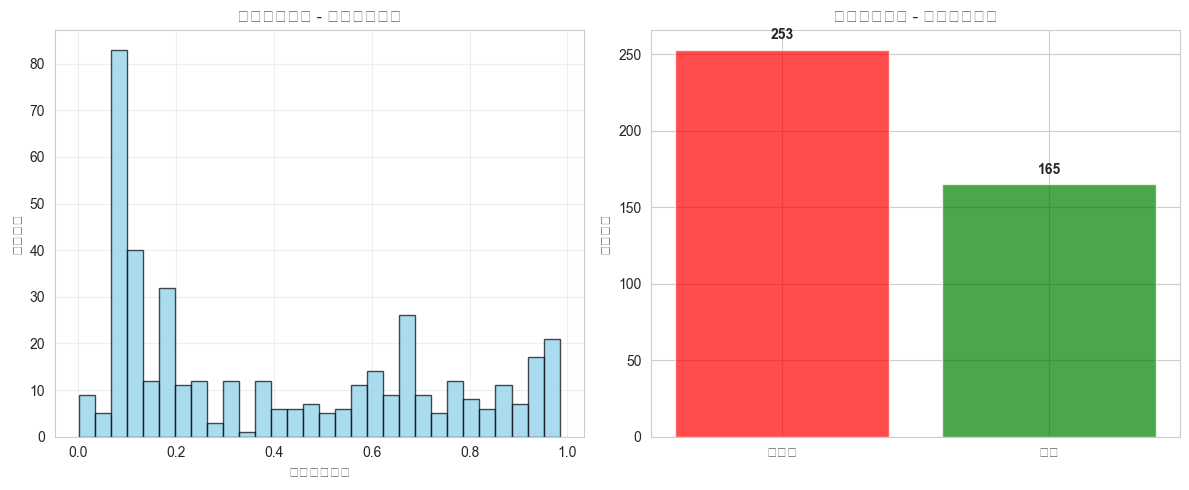


=== 注意 ===
測試資料不包含真實答案，無法進行ROC分析
僅顯示預測結果


In [6]:
# 對外部測試資料進行預測
y_pred_test = log_reg.predict(X_test)
y_pred_proba_test = log_reg.predict_proba(X_test)[:, 1]

print(f"外部測試資料預測完成！")
print(f"預測為生還的乘客數: {np.sum(y_pred_test)}")
print(f"預測為未生還的乘客數: {len(y_pred_test) - np.sum(y_pred_test)}")
print(f"生還率預測: {np.mean(y_pred_test):.4f}")

# 顯示預測機率分布
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba_test, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('預測生還機率')
plt.ylabel('乘客數量')
plt.title('外部測試資料 - 預測機率分布')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
survival_counts = pd.Series(y_pred_test).value_counts().sort_index()
plt.bar(['未生還', '生還'], survival_counts.values, color=['red', 'green'], alpha=0.7)
plt.ylabel('乘客數量')
plt.title('外部測試資料 - 預測結果分布')
for i, v in enumerate(survival_counts.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 如果測試資料有真實答案，則進行ROC分析
if y_test is not None:
    print("\n=== ROC曲線分析 ===")
    print("測試資料包含真實答案，進行ROC分析...")
    
    # 計算ROC曲線的數據點
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
    
    # 計算AUC值
    roc_auc = auc(fpr, tpr)
    
    # 計算測試集上的準確率
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    print(f"測試集準確率: {test_accuracy:.4f}")
    print(f"AUC值: {roc_auc:.4f}")
    print("測試集混淆矩陣:")
    print(test_conf_matrix)
else:
    print("\n=== 注意 ===")
    print("測試資料不包含真實答案，無法進行ROC分析")
    print("僅顯示預測結果")

## 6. ROC曲線繪製（僅當有真實答案時）

In [7]:
# 只有當測試資料有真實答案時才繪製ROC曲線
if y_test is not None:
    # 繪製ROC曲線
    plt.figure(figsize=(10, 8))
    
    # 繪製ROC曲線
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC曲線 (AUC = {roc_auc:.4f})')
    
    # 繪製對角線（隨機分類器的基準線）
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='隨機分類器 (AUC = 0.5)')
    
    # 設定圖表屬性
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('偽陽性率 (False Positive Rate)', fontsize=12)
    plt.ylabel('真陽性率 (True Positive Rate)', fontsize=12)
    plt.title('羅吉斯迴歸模型 - ROC曲線 (外部測試資料)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # 添加AUC值的文字說明
    plt.text(0.6, 0.2, f'AUC = {roc_auc:.4f}\n\n解釋:\n• AUC > 0.9: 優秀\n• AUC > 0.8: 良好\n• AUC > 0.7: 尚可\n• AUC > 0.6: 差\n• AUC ≤ 0.5: 無效', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
             fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n由於測試資料沒有真實答案，無法繪製ROC曲線")
    print("如需ROC分析，請使用包含Survived欄位的測試資料")


由於測試資料沒有真實答案，無法繪製ROC曲線
如需ROC分析，請使用包含Survived欄位的測試資料


## 7. 詳細分析（僅當測試資料有答案時）

In [8]:
# 只有當測試資料有真實答案時才進行詳細分析
if y_test is not None:
    # 創建更詳細的ROC分析圖表
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. ROC曲線
    axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC曲線 (AUC = {roc_auc:.4f})')
    axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='隨機分類器')
    axes[0, 0].set_xlim([0.0, 1.0])
    axes[0, 0].set_ylim([0.0, 1.05])
    axes[0, 0].set_xlabel('偽陽性率 (FPR)')
    axes[0, 0].set_ylabel('真陽性率 (TPR)')
    axes[0, 0].set_title('ROC曲線')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 預測機率分布
    survived_proba = y_pred_proba_test[y_test == 1]
    not_survived_proba = y_pred_proba_test[y_test == 0]
    
    axes[0, 1].hist(not_survived_proba, bins=30, alpha=0.7, label='未生還', color='red', density=True)
    axes[0, 1].hist(survived_proba, bins=30, alpha=0.7, label='生還', color='green', density=True)
    axes[0, 1].set_xlabel('預測機率')
    axes[0, 1].set_ylabel('密度')
    axes[0, 1].set_title('預測機率分布（按真實結果分組）')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 閾值 vs 精確率/召回率
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba_test)
    
    # 為了與ROC的閾值對應，我們需要計算每個閾值下的精確率和召回率
    precisions = []
    recalls = []
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba_test >= threshold).astype(int)
        if len(np.unique(y_pred_threshold)) > 1:  # 避免除零錯誤
            prec = precision_score(y_test, y_pred_threshold, zero_division=0)
            rec = recall_score(y_test, y_pred_threshold, zero_division=0)
        else:
            prec = 0
            rec = 0
        precisions.append(prec)
        recalls.append(rec)
    
    axes[1, 0].plot(thresholds, precisions, label='精確率 (Precision)', color='blue')
    axes[1, 0].plot(thresholds, recalls, label='召回率 (Recall)', color='red')
    axes[1, 0].set_xlabel('閾值')
    axes[1, 0].set_ylabel('分數')
    axes[1, 0].set_title('閾值 vs 精確率/召回率')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 混淆矩陣熱力圖
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['未生還', '生還'], 
                yticklabels=['未生還', '生還'],
                ax=axes[1, 1])
    axes[1, 1].set_title('測試集混淆矩陣')
    axes[1, 1].set_xlabel('預測值')
    axes[1, 1].set_ylabel('實際值')
    
    plt.tight_layout()
    plt.show()
else:
    print("測試資料沒有真實答案，跳過詳細ROC分析")
    
    # 顯示預測結果的詳細統計
    print("\n=== 預測結果統計 ===")
    print(f"總乘客數: {len(y_pred_test)}")
    print(f"預測生還: {np.sum(y_pred_test)} 人 ({np.mean(y_pred_test)*100:.1f}%)")
    print(f"預測未生還: {len(y_pred_test) - np.sum(y_pred_test)} 人 ({(1-np.mean(y_pred_test))*100:.1f}%)")
    
    # 顯示預測機率的統計
    print(f"\n=== 預測機率統計 ===")
    print(f"平均預測機率: {np.mean(y_pred_proba_test):.4f}")
    print(f"機率標準差: {np.std(y_pred_proba_test):.4f}")
    print(f"最高預測機率: {np.max(y_pred_proba_test):.4f}")
    print(f"最低預測機率: {np.min(y_pred_proba_test):.4f}")

測試資料沒有真實答案，跳過詳細ROC分析

=== 預測結果統計 ===
總乘客數: 418
預測生還: 165 人 (39.5%)
預測未生還: 253 人 (60.5%)

=== 預測機率統計 ===
平均預測機率: 0.4038
機率標準差: 0.3165
最高預測機率: 0.9841
最低預測機率: 0.0011


## 8. 模型效能總結

In [9]:
print("=" * 60)
print("羅吉斯迴歸模型效能總結")
print("=" * 60)

# 訓練集效能
print("\n【訓練集效能】")
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print(f"準確率 (Accuracy):    {train_accuracy:.4f}")
print(f"精確率 (Precision):   {train_precision:.4f}")
print(f"召回率 (Recall):      {train_recall:.4f}")
print(f"F1分數 (F1-Score):    {train_f1:.4f}")

# 外部測試集效能（如果有答案）
if y_test is not None:
    print("\n【外部測試集效能】")
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    
    print(f"準確率 (Accuracy):    {test_accuracy:.4f}")
    print(f"精確率 (Precision):   {test_precision:.4f}")
    print(f"召回率 (Recall):      {test_recall:.4f}")
    print(f"F1分數 (F1-Score):    {test_f1:.4f}")
    print(f"AUC值:               {roc_auc:.4f}")
    
    # ROC曲線解釋
    print("\n【ROC曲線分析】")
    print(f"• AUC值為 {roc_auc:.4f}，", end="")
    if roc_auc > 0.9:
        print("模型效能優秀")
    elif roc_auc > 0.8:
        print("模型效能良好")
    elif roc_auc > 0.7:
        print("模型效能尚可")
    elif roc_auc > 0.6:
        print("模型效能較差")
    else:
        print("模型幾乎無預測能力")
    
    print(f"• 模型在區分生還與未生還乘客方面有 {(roc_auc-0.5)*200:.1f}% 的改善（相較於隨機猜測）")
    
    # 找到最佳閾值（Youden's J statistic）
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"• 建議的最佳分類閾值: {optimal_threshold:.4f}")
    print(f"  在此閾值下，TPR = {tpr[optimal_idx]:.4f}, FPR = {fpr[optimal_idx]:.4f}")
else:
    print("\n【外部測試集預測】")
    print(f"總預測樣本數:        {len(y_pred_test)}")
    print(f"預測生還人數:        {np.sum(y_pred_test)}")
    print(f"預測生還率:          {np.mean(y_pred_test):.4f}")
    print(f"平均預測機率:        {np.mean(y_pred_proba_test):.4f}")
    print("\n注意: 由於測試資料無真實答案，無法計算準確率和AUC值")

print("\n" + "=" * 60)

羅吉斯迴歸模型效能總結

【訓練集效能】
準確率 (Accuracy):    0.8339
精確率 (Precision):   0.8031
召回率 (Recall):      0.7515
F1分數 (F1-Score):    0.7764

【外部測試集預測】
總預測樣本數:        418
預測生還人數:        165
預測生還率:          0.3947
平均預測機率:        0.4038

注意: 由於測試資料無真實答案，無法計算準確率和AUC值



## 9. 保存預測結果

In [10]:
# 創建預測結果的DataFrame
if 'PassengerId' in test_df.columns:
    results_df = pd.DataFrame({
        'PassengerId': test_df['PassengerId'],
        'Survived': y_pred_test,
        'Survival_Probability': y_pred_proba_test
    })
else:
    results_df = pd.DataFrame({
        'Index': range(len(y_pred_test)),
        'Survived': y_pred_test,
        'Survival_Probability': y_pred_proba_test
    })

# 顯示前10筆預測結果
print("前10筆預測結果:")
print(results_df.head(10))

# 保存預測結果到CSV檔案
output_path = '../data/predictions_logistic_regression_raw_data.csv'
results_df.to_csv(output_path, index=False)
print(f"\n預測結果已保存至: {output_path}")

# 顯示預測結果統計
print(f"\n預測結果統計:")
print(f"總樣本數: {len(results_df)}")
print(f"預測生還: {results_df['Survived'].sum()} 人")
print(f"預測未生還: {len(results_df) - results_df['Survived'].sum()} 人")
print(f"生還率: {results_df['Survived'].mean():.4f}")

前10筆預測結果:
   PassengerId  Survived  Survival_Probability
0          892         0              0.107541
1          893         1              0.644597
2          894         0              0.135630
3          895         0              0.081577
4          896         1              0.562174
5          897         0              0.091141
6          898         1              0.668151
7          899         0              0.114186
8          900         1              0.799836
9          901         0              0.053398

預測結果已保存至: ../data/predictions_logistic_regression_raw_data.csv

預測結果統計:
總樣本數: 418
預測生還: 165 人
預測未生還: 253 人
生還率: 0.3947
